In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-22 14:21:42.827318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 14:21:42.841413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 14:21:42.845648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG','P2L'], 
                    #'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          #'mag_nabla_h_widened',
                                          #'filter_scale', 
                                          #'mag_nabla_u_widened',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : ['uphp_rotated',
                                        'vphp_rotated', 
                                        'mag_nabla_h_widened',
                                        'mag_nabla_u_widened',
                                        'filter_scale'],

                    'use_coeff_channels': False,

                    # These are the same snapshot choices as what was used to train model. 
                    'all_time_range': slice(200, 3600),
                    'train_time_range': slice(0, 2048),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [48, 48, 2],
                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/'
                    #'network_shape': [36, 36, 2],
                    #'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

In [3]:
experiment_config['nontrain_time_range'] = slice(2048, 3600)
#experiment_config['full_eval_time_range'] = slice(0, 3600-2048)

In [4]:
%%time
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['nontrain_time_range'],
                             single_layer_mask_flag=True)

CPU times: user 1min 18s, sys: 20.9 s, total: 1min 39s
Wall time: 1min 33s


In [5]:
exp_sets = { #'DG_only': { 'sel_sim' :'DG' }, 
             #'P2L_only':{ 'sel_sim' :'P2L' }, 
             'DG_P2L':{'sel_sim' :['DG','P2L']}   
            }

for set_keys in exp_sets.keys(): 
    exp_sets[set_keys]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + set_keys


In [6]:
# Load in and get the models ready to evaluate
for set_keys in exp_sets.keys():
    print(exp_sets[set_keys]['save_dir'])
    exp_sets[set_keys]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                             input_channels=experiment_config['input_channels'],
                                             output_channels=experiment_config['output_channels'], 
                                             coeff_channels=experiment_config['coeff_channels'], 
                                             extra_channels=experiment_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= experiment_config['eval_time_range'], 
                                             num_inputs=experiment_config['num_inputs'], 
                                             shape=experiment_config['network_shape'], 
                                             ckpt_dir=exp_sets[set_keys]['save_dir'],
                                             use_coeff_channels=experiment_config['use_coeff_channels'])

    
    exp_sets[set_keys]['eval_sys'].read_ann_regression_model()
    exp_sets[set_keys]['eval_sys'].read_eval_data()
    exp_sets[set_keys]['eval_sys'].predict()
    exp_sets[set_keys]['eval_sys'].dimensionalize()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/shape_48_48_2/DG_P2L


In [7]:
eval_sys = exp_sets[set_keys]['eval_sys']

In [65]:
eval_sys.regress_sys.network.count_parameters()

5090

In [8]:
ds = eval_sys.eval_datatree.ml_dataset['DG']['100']

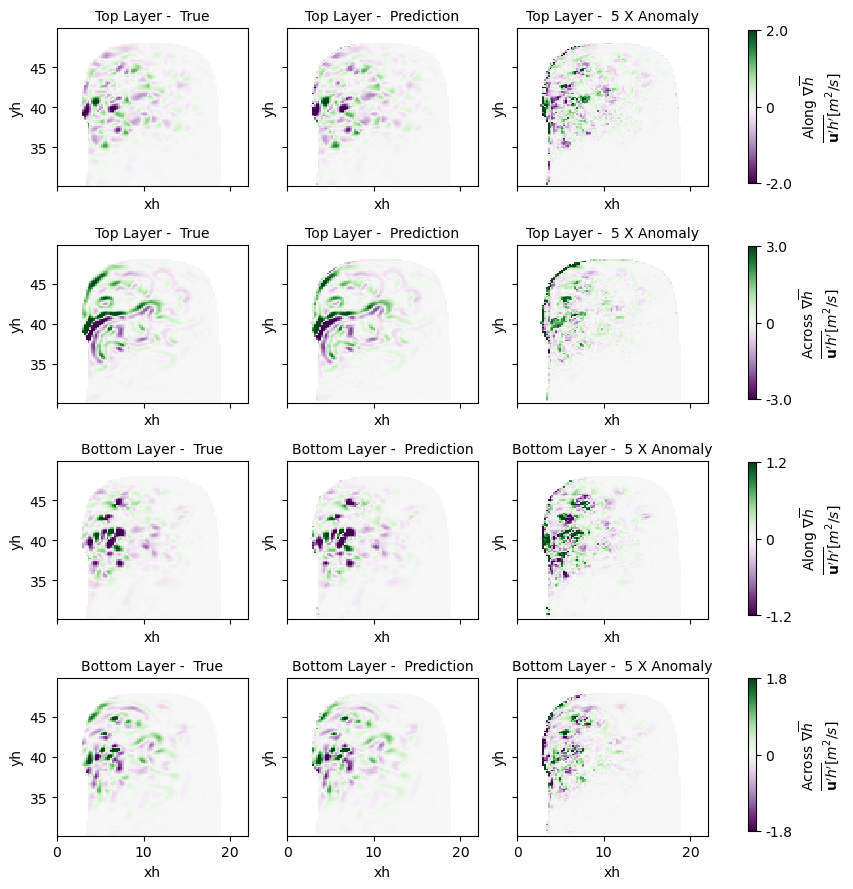

In [60]:
import matplotlib.pyplot as plt

# Select the first time index
time_idx = 0

# Define layer labels
layer_labels = ["Top Layer", "Bottom Layer"]

# Define separate vmin/vmax for each combination
vmin_uphp_top, vmax_uphp_top = -2, 2
vmin_vphp_top, vmax_vphp_top = -3., 3.
vmin_uphp_bottom, vmax_uphp_bottom = -1.2, 1.2
vmin_vphp_bottom, vmax_vphp_bottom = -1.8, 1.8

# **Slightly reduce panel height** (A4 width, slightly shorter height)
fig, axes = plt.subplots(4, 3, figsize=(8.27, 9), sharex=True, sharey=True)

# Define datasets per variable
data_vars = [
    ds.uphp_rotated, ds.uphp_rotated_pred, 5*(ds.uphp_rotated - ds.uphp_rotated_pred),
    ds.vphp_rotated, ds.vphp_rotated_pred, 5*(ds.vphp_rotated - ds.vphp_rotated_pred)
]

titles = ["True", "Prediction", "5 X Anomaly"]

# Iterate over layers (zl=0 → Top Layer, zl=1 → Bottom Layer)
for row, zl in enumerate([0, 1]):  # zl index order
    # Set vmin/vmax based on the layer
    row2 = row*2
    if row == 0:  # Top Layer
        vmin_uphp, vmax_uphp = vmin_uphp_top, vmax_uphp_top
        vmin_vphp, vmax_vphp = vmin_vphp_top, vmax_vphp_top
    else:  # Bottom Layer
        vmin_uphp, vmax_uphp = vmin_uphp_bottom, vmax_uphp_bottom
        vmin_vphp, vmax_vphp = vmin_vphp_bottom, vmax_vphp_bottom

    for col in range(3):  # (Original, Prediction, Anomaly)
        uphp_ax = axes[2 * row, col]  # Rows 0, 2 for uphp
        vphp_ax = axes[2 * row + 1, col]  # Rows 1, 3 for vphp
        
        # Plot uphp_rotated with adjusted vmin/vmax
        im1 = data_vars[col].isel(zl=zl, Time=time_idx).plot(
            ax=uphp_ax, add_colorbar=False, vmin=vmin_uphp, vmax=vmax_uphp, cmap="PRGn"
        )
        uphp_ax.set_title(f"{layer_labels[row]} -  {titles[col]}", fontsize=10)
        
        # Plot vphp_rotated with adjusted vmin/vmax
        im2 = data_vars[col + 3].isel(zl=zl, Time=time_idx).plot(
            ax=vphp_ax, add_colorbar=False, vmin=vmin_vphp, vmax=vmax_vphp, cmap="PRGn"
        )
        vphp_ax.set_title(f"{layer_labels[row]} -  {titles[col]}", fontsize=10)

    cbar_ax = fig.add_axes([0.91, 0.79 - row2 * 0.24, 0.01, 0.17])
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.set_label("Along "+r"$\nabla \overline{h}$"+' \n'+ "$\overline{\mathbf{u}'h'} [m^2/s]$")
    cbar.set_ticks([vmin_uphp, 0, vmax_uphp])
    cbar.ax.set_yticklabels([f"{vmin_uphp:.1f}", "0", f"{vmax_uphp:.1f}"])

    cbar_ax = fig.add_axes([0.91, 0.79 - (row2 + 1) * 0.24, 0.01, 0.17])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.set_label("Across "+r"$\nabla \overline{h}$"+' \n'+ "$\overline{\mathbf{u}'h'} [m^2/s]$")
    cbar.set_ticks([vmin_vphp, 0, vmax_vphp])
    cbar.ax.set_yticklabels([f"{vmin_vphp:.1f}", "0", f"{vmax_vphp:.1f}"])

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.88, 1])  # **Better spacing for colorbars**

plt.savefig('maps_ML_skill.png', dpi=250)